In [1]:
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a GPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'GPU'** in the dropdown.

import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ddpg import train as ddpg

from brax.io import image
from PIL import Image
import io, base64


if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

2025-03-28 19:11:32.169497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743214292.185711   89322 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743214292.191215   89322 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743214292.206363   89322 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743214292.206380   89322 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743214292.206383   89322 computation_placer.cc:177] computation placer alr

In [2]:
#@title Load Env { run: "auto" }

env_name = 'classic_pendulum'  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']
backend = 'positional'  # @param ['generalized', 'positional', 'spring']

env = envs.get_environment(env_name=env_name,
                           backend=backend)
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

# HTML(html.render(env.sys, [state.pipeline_state]))

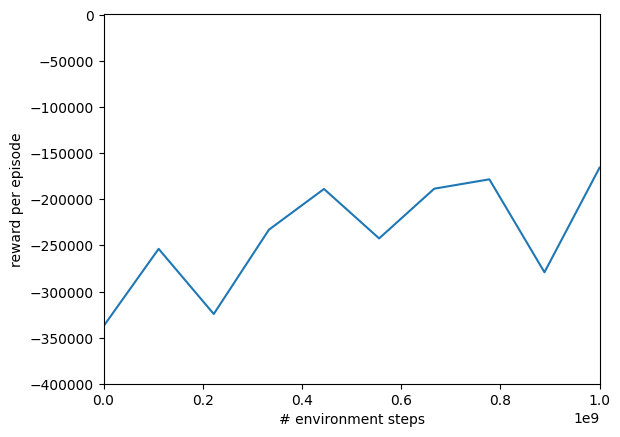

time to jit: 0:00:14.636042
time to train: 0:03:19.358242


In [3]:
train_fn = {
    'classic_pendulum': functools.partial(ddpg.train,  num_timesteps=1_000_000_000, num_evals=10, reward_scaling=10, episode_length=200, normalize_observations=True, action_repeat=5, discounting=0.997, learning_rate=6e-4, num_envs=4096, batch_size=2048, seed=1)
}[env_name]

max_y = 1_000
min_y = -400_000

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [4]:
model.save_params('/tmp/params', params)
params = model.load_params('/tmp/params')
inference_fn = make_inference_fn(params)

In [5]:
#@title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=42)
state = jit_env_reset(rng=rng)
for i in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)


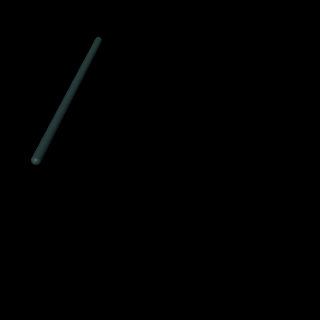

In [6]:

# render each pipeline state to an RGB array
frames = image.render_array(env.sys, rollout, height=320, width=320)

# convert all frames to PIL images
frames_pil = [Image.fromarray(f) for f in frames]

frames_pil[0].save(
    'pendulum_ddpg.gif',
    format='GIF',
    append_images=frames_pil[1:],   # the rest of the frames
    save_all=True,
    duration=1000/30,  # ~30 fps
    loop=0,
)
# write a GIF in-memory
buf = io.BytesIO()
frames_pil[0].save(
    buf, 
    format='GIF',
    append_images=frames_pil[1:], 
    save_all=True, 
    duration=1000/30,   # ~30 fps
    loop=0
)

# embed the GIF in the notebook
gif_data = buf.getvalue()
HTML(f'<img src="data:image/gif;base64,{base64.b64encode(gif_data).decode("utf-8")}"/>')
